![Austin Skyline](https://images.assetsdelivery.com/compings_v2/ongkachakon/ongkachakon1704/ongkachakon170400085.jpg)

# Visualizing Restaurants in Austin Neighborhoods

**_Installing the required libraries_**

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analysis
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
# Uncomment to install Python Geocoding ToolBox
#!pip install geopy 
# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
# transforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Uncomment to install Folium
#!pip install folium
import folium 
# Uncomment to install sodapy
#!pip install sodapy
# Uncomment to install bokeh
#!pip install pandas-bokeh
# Uncomment to install GeoPandas
#!pip install geopandas
# Uncomment to install yellowbrick: a diagnostic tool for machine learning
#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
print('All necessary libraries are installed..ready to roll')

All necessary libraries are installed..ready to roll


In [5]:
# Importing data from the Austin Government website
from sodapy import Socrata
# First 2000 results, returned as JSON from API / converted to Python list of dictionaries by sodapy
client = Socrata("data.austintexas.gov",None)
results = client.get("nz5f-3t2e",limit=2000)
# Convert to pandas DataFrame
df_neighbors = pd.DataFrame.from_records(results)
df_neighbors.head()

,the_geom,_feature_i,planning_a,shape_area,shape_leng,label
0,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...",1.0,ALLANDALE,65792689.5531,42253.1072105,Allandale
1,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...",2.0,BARTON HILLS,88901714.7947,48353.9339254,Barton Hills
2,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...",3.0,BOULDIN CREEK,33258999.9494,25667.3403756,Bouldin Creek
3,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...",4.0,BRENTWOOD,44207756.068,29612.4036976,Brentwood
4,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...",5.0,CENTRAL EAST AUSTIN,26970983.8606,22198.5298969,Central East Austin


In [6]:
import pandas as pd
import geopandas as gpd
# Read the GeoJson file 
df_boundaries = gpd.read_file("data/Boundaries_ Austin Neighborhood Planning Areas.geojson")
df_boundaries.head()

,planning_a,shape_area,label,shape_leng,_feature_i,geometry
0,ALLANDALE,65792689.5531,Allandale,42253.1072105,1.0,"MULTIPOLYGON (((-97.73974 30.32808, -97.73962 ..."
1,BARTON HILLS,88901714.7947,Barton Hills,48353.9339254,2.0,"MULTIPOLYGON (((-97.79627 30.23398, -97.79767 ..."
2,BOULDIN CREEK,33258999.9494,Bouldin Creek,25667.3403756,3.0,"MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ..."
3,BRENTWOOD,44207756.068,Brentwood,29612.4036976,4.0,"MULTIPOLYGON (((-97.73692 30.31449, -97.73757 ..."
4,CENTRAL EAST AUSTIN,26970983.8606,Central East Austin,22198.5298969,5.0,"MULTIPOLYGON (((-97.71925 30.27073, -97.71903 ..."


In [4]:
import pandas_bokeh
pandas_bokeh.output_notebook()
# Quick plot of the neighbohood boundaries
df_boundaries.plot_bokeh(
    title="Neighborhood boundaries of Austin",
    figsize=(900,600),
    simplify_shapes=10,
    show_colorbar=False,
    color ="green",
    fill_alpha = 0.65,
    line_color = 'white', 
    line_width = 0.85,
    tile_provider="STAMEN_TERRAIN_RETINA"
)

Loading BokehJS ...

Figure(id='1002', ...)

In [7]:
# Renaming the geometry column to borders
df_boundaries = df_boundaries.rename(columns={'geometry':'borders'}).set_geometry('borders')
# Now, we create centroids and make it the geometry
df_boundaries['centroid_column']=df_boundaries.centroid
df_boundaries = df_boundaries.set_geometry('centroid_column')
df_boundaries.head()

,planning_a,shape_area,label,shape_leng,_feature_i,borders,centroid_column
0,ALLANDALE,65792689.5531,Allandale,42253.1072105,1.0,"MULTIPOLYGON (((-97.73974 30.32808, -97.73962 ...",POINT (-97.74517 30.34030)
1,BARTON HILLS,88901714.7947,Barton Hills,48353.9339254,2.0,"MULTIPOLYGON (((-97.79627 30.23398, -97.79767 ...",POINT (-97.78837 30.25202)
2,BOULDIN CREEK,33258999.9494,Bouldin Creek,25667.3403756,3.0,"MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...",POINT (-97.75563 30.25170)
3,BRENTWOOD,44207756.068,Brentwood,29612.4036976,4.0,"MULTIPOLYGON (((-97.73692 30.31449, -97.73757 ...",POINT (-97.73245 30.33062)
4,CENTRAL EAST AUSTIN,26970983.8606,Central East Austin,22198.5298969,5.0,"MULTIPOLYGON (((-97.71925 30.27073, -97.71903 ...",POINT (-97.72415 30.26974)


In [8]:
# Let's create a new dataframe
df_austin = df_boundaries.copy()
# Let's drop columns not needed
df_austin.drop(['planning_a','shape_area','shape_leng','_feature_i','borders'], axis=1, inplace=True)
# Let's extract longitude & latitude values from centroid_column
df_austin['Latitude']=df_austin['centroid_column'].apply(lambda p: p.y)
df_austin['Longitude']=df_austin['centroid_column'].apply(lambda p: p.x)
# Let's rename two columns of the final DataFrame
df_austin.rename(columns={'label':'Neighborhood','centroid_column':'Centroid'},inplace=True)
print("Shape of dataframe of Austin Neighborhoods:",df_austin.shape)
df_austin.head()

Shape of dataframe of Austin Neighborhoods: (65, 4)


,Neighborhood,Centroid,Latitude,Longitude
0,Allandale,POINT (-97.74517 30.34030),30.340301,-97.745169
1,Barton Hills,POINT (-97.78837 30.25202),30.252021,-97.788367
2,Bouldin Creek,POINT (-97.75563 30.25170),30.251705,-97.755626
3,Brentwood,POINT (-97.73245 30.33062),30.330625,-97.732451
4,Central East Austin,POINT (-97.72415 30.26974),30.269742,-97.724153


In [9]:
from geopy.geocoders import Nominatim 
address = 'Austin, Texas, USA'
geolocator = Nominatim(user_agent="austin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Austin are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Austin are 30.2711286, -97.7436995.


In [9]:
# Create map of Austin using latitude and longitude values
map_austin = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(df_austin['Latitude'], df_austin['Longitude'], df_austin['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
# Save map 
map_austin.save("figs/Austin_Map.html")
# Display map   
HTML(map_austin._repr_html_())

## Define Foursquare Credentials and Version

In [10]:
# @hidden_cell
CLIENT_ID = 'JMIGUGAB13UKJUZ5XKKDXQGBABAH3LIVPXH4GEU015CHIYBH' # my Foursquare ID
CLIENT_SECRET = 'K0LO1KATAYLIAYXENGLM11VPJW0POWBABAEQEGW5UAMZJ4OR' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

**_Let's get the name, latitude and longitude of the first neighborhood in the DataFrame_**

In [11]:
neighborhood_latitude = df_austin.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_austin.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = df_austin.loc[0, 'Neighborhood'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name,neighborhood_latitude,neighborhood_longitude))

Latitude and longitude values of Allandale are 30.34030091175344, -97.74516940787922.


![Allandale_Austin](https://www.paulypresleyrealty.com/uploads/agent-1/allandale-northwest-district-park-lake-view.jpg)\
**_photo credit:https://www.paulypresleyrealty.com/blog/allandale-austin-neighborhood-spotlight.html_**

#### Let's get the top 100 venues that are in Allandale within a radius of 1000 meters

In [12]:
# Define the radius and limit
radius = 1000
LIMIT = 100
# Create the url
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
# Send the GET request and examine results
results = requests.get(url).json()
# Uncomment the following line to print results
# results

#### Let's define a function: get_category_type that extracts the category of the venue

In [13]:
# function get_category_type
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
from pandas.io.json import json_normalize
# Create a dataframe venues
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print("Shape of nearby venues of Allandale neighborhood:",nearby_venues.shape)
nearby_venues.head(10)

Shape of nearby venues of Allandale neighborhood: (38, 4)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Barley Swine,New American Restaurant,30.341256,-97.738458
1,Yard Bar,Bar,30.342881,-97.738871
2,Bufalina Due,Pizza Place,30.341030,-97.738422
3,Three Little Pigs,Food Truck,30.340192,-97.738426
4,Lick Ice Creams Burnet Road,Ice Cream Shop,30.341143,-97.738408
5,Taqueria Arandas No. 3,Mexican Restaurant,30.341555,-97.739067
6,Growler Room,Food & Drink Shop,30.344500,-97.738420
7,Asahi Imports,Supermarket,30.336347,-97.739225
8,Hot Rod Coffee Trailer,Food Truck,30.341761,-97.738946
9,The Aristocrat Lounge,Lounge,30.340241,-97.738617


In [21]:
# Let's check the venue categories in Allandale Neighborhood
# nearby_venues['categories'].value_counts().nlargest(10)
df_allandale = pd.DataFrame(nearby_venues['categories'].value_counts(dropna=True,sort=True)).reset_index()
df_allandale = df_allandale.rename(columns={'index':'Categories','categories':'Count'})
df_allandale.head(10)

,Categories,Count
0,Food Truck,3
1,Mexican Restaurant,2
2,Pizza Place,2
3,Cosmetics Shop,1
4,Grocery Store,1
5,Supermarket,1
6,Thai Restaurant,1
7,Video Store,1
8,Food & Drink Shop,1
9,New American Restaurant,1


**_Most popular venues around Allandale are food trucks followed by Pizza places & Mexican Restaurants_**

### Let's explore all the Neighborhoods in Austin

**_We have already explored the first neighborhood, let's create a function that would repeat for all neighborhoods_**

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # Uncomment the following line to print name 
        # print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
             name, 
        #    lat, 
        #    lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  #'Neighborhood Latitude', 
                  #'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [17]:
austin_venues = getNearbyVenues(names=df_austin['Neighborhood'],
                                   latitudes=df_austin['Latitude'],
                                   longitudes=df_austin['Longitude']
                                  )
print("Finished exploring all the neighborhood venues in Austin")

Finished exploring all the neighborhood venues in Austin


In [19]:
print("Shape of nearby venues dataframe:",austin_venues.shape)
austin_venues.head(10)

Shape of nearby venues dataframe: (3234, 5)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allandale,Barley Swine,30.341256,-97.738458,New American Restaurant
1,Allandale,Yard Bar,30.342881,-97.738871,Bar
2,Allandale,Bufalina Due,30.341030,-97.738422,Pizza Place
3,Allandale,Three Little Pigs,30.340192,-97.738426,Food Truck
4,Allandale,Lick Ice Creams Burnet Road,30.341143,-97.738408,Ice Cream Shop
5,Allandale,Taqueria Arandas No. 3,30.341555,-97.739067,Mexican Restaurant
6,Allandale,Growler Room,30.344500,-97.738420,Food & Drink Shop
7,Allandale,Asahi Imports,30.336347,-97.739225,Supermarket
8,Allandale,Hot Rod Coffee Trailer,30.341761,-97.738946,Food Truck
9,Allandale,The Aristocrat Lounge,30.340241,-97.738617,Lounge


In [20]:
# Let's check the venue categories in Austin Neighborhoods
df_venue_cat = pd.DataFrame(austin_venues['Venue Category'].value_counts(dropna=True,sort=True)).reset_index()
df_venue_cat = df_venue_cat.rename(columns={'index':'Categories','categories':'Count'})
df_venue_cat.head(10)

,Categories,Venue Category
0,Mexican Restaurant,143
1,Food Truck,131
2,Coffee Shop,114
3,Park,73
4,Sandwich Place,71
5,Bar,71
6,Convenience Store,69
7,Hotel,69
8,Pizza Place,68
9,Taco Place,59


**_Mexican Restaurants are most popular in Austin followed by Food Trucks & Coffee Shops_**

### Let's check how many venues were returned for each neighborhood

In [20]:
# Let's create a new dataframe which containes the top 10 neighborhoods that returned maximum number of venues
df_venue_no = austin_venues[['Neighborhood','Venue']].groupby('Neighborhood')['Venue'].size().nlargest(10).reset_index(name = 'Venues')
df_venue_no.head(10)

,Neighborhood,Venues
0,Bouldin Creek,100
1,Central East Austin,100
2,Downtown,100
3,East Cesar Chavez,100
4,Gateway,100
5,Riverside,100
6,UT,100
7,West University,100
8,Zilker,100
9,North University,89


![Gateway_Neighborhood](https://communityimpact.com/wp-content/uploads/2018/05/NWA-2018-05-22-1.jpg)\
**_Gateway Neighborhood is where Austin's second downtown takes shape, it returned large number of venues along with other neighborhoods in central austin_**

**_Let's find out how many unique categories are present in all the returned venues_**

In [22]:
print('There are {} uniques categories.'.format(len(austin_venues['Venue Category'].unique())))

There are 319 uniques categories.


## Analyze Each Neighborhood

In [27]:
# one hot encoding to create dummy columns
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']],prefix="",prefix_sep="")
# add neighborhood column back to dataframe
austin_onehot['Neighborhood'] = austin_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
# create the DataFrame
austin_onehot = austin_onehot[fixed_columns]
# Display austin_onehot
print("Shape of one hot encoded dataframe of venues in Austin neighborhood:",austin_onehot.shape)
austin_onehot.head()

Shape of one hot encoded dataframe of venues in Austin neighborhood: (3234, 319)


,Yoga Studio,ATM,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
austin_grouped = austin_onehot.groupby('Neighborhood').mean().reset_index()
print("Shape of grouped neighborhood dataframe:",austin_grouped.shape)
austin_grouped.head()

Shape of grouped neighborhood dataframe: (65, 319)


,Neighborhood,Yoga Studio,ATM,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,Allandale,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,...,0.026316,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,Barton Hills,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,Bouldin Creek,0.010000,0.0,0.0,0.0,0.010000,0.000000,0.0,0.00,0.0,...,0.000000,0.010000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,Brentwood,0.014085,0.0,0.0,0.0,0.028169,0.028169,0.0,0.00,0.0,...,0.014085,0.014085,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,Central East Austin,0.030000,0.0,0.0,0.0,0.010000,0.000000,0.0,0.01,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0


### Let's check how many food trucks are in each neighborhoods

In [29]:
# Create a new DataFrame for Food trucks arranged in descending order
austin_truck = pd.DataFrame(austin_grouped[['Neighborhood', 'Food Truck']].sort_values(by=['Food Truck'],ascending=False))
# Reset index of the new dataframe
austin_truck.reset_index(drop=True,inplace=True)
austin_truck.head(10)

,Neighborhood,Food Truck
0,Central East Austin,0.160000
1,Southeast,0.125000
2,MLK-183,0.111111
3,East Cesar Chavez,0.090000
4,Georgian Acres,0.086957
5,Montopolis,0.083333
6,West Congress,0.083333
7,Franklin Park,0.083333
8,South River City,0.082192
9,Old Enfield,0.080000


**_Barton Hills neighborhood has the most number of Food Trucks followed by Central East Austin neighborhood_**

### Let's create a DataFrame that contains all the restaurants and food trucks in Austin Neighborhoods

In [30]:
# Create a new DataFrame for all restaurants
m = np.core.defchararray.find(austin_grouped.columns.values.astype(str),'Restaurant') >=0
austin_restaurant = pd.DataFrame(austin_grouped.values[:,m],austin_grouped.index,austin_grouped.columns[m])
# Another DataFrame for Food Truck
austin_truck2 = pd.DataFrame(austin_grouped[['Neighborhood', 'Food Truck']])
# Combine both the dataframes to create a 
austin_res = pd.merge(austin_truck2,austin_restaurant,left_on=austin_truck2.index,right_on=austin_truck2.index,how='left')
austin_res.drop(['key_0'], axis = 1, inplace = True)
print("Shape of resturants dataframe:",austin_res.shape)
austin_res.head()

Shape of resturants dataframe: (65, 47)


,Neighborhood,Food Truck,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,...,Southern / Soul Food Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Allandale,0.078947,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0263158,0,0,0
1,Barton Hills,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bouldin Creek,0.050000,0,0.01,0,0,0,0,0,0,...,0,0.01,0,0,0.01,0,0.03,0,0.02,0.01
3,Brentwood,0.014085,0,0.028169,0,0.0140845,0,0,0,0,...,0,0,0,0,0,0,0.028169,0,0,0.0140845
4,Central East Austin,0.160000,0,0.01,0.01,0.01,0.01,0,0,0.01,...,0,0,0,0,0,0,0.01,0,0,0


# Segmenting Austin neighborhoods based on Restaurants & food trucks

### Let's see the list of 5 top most common resturants in Austin neighborhoods

In [38]:
# Number of top 5 most common venues
num_top_venues = 5
# Creating the list of top 5 most common venues
for hood in austin_res['Neighborhood']:
    # uncomment to print the neighborhood in first line
    # print("----" + hood + "----") 
    temp = austin_res[austin_res['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq'] # Column headings
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float) # Freq is cast as float
    temp = temp.round({'freq': 2}) # Rounded by two decimal points
    # uncomment the following lines to see the top 5 venues from all neighborhoods
    # print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    # print('\n')

### Let's cast a list of 10 most popular restaurants in each neighborhood into a pandas dataframe

**_Let's define a function to sort the venues in descending order_**

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**_Let's create the new dataframe and display the top 10 restaurants for each neighborhood_**

In [33]:
num_top_venues = 10
# These indicators will be used to write the 1st 3 column headers
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighborhoods_res_sorted = pd.DataFrame(columns=columns)
neighborhoods_res_sorted['Neighborhood'] = austin_res['Neighborhood']
for ind in np.arange(austin_res.shape[0]):
    neighborhoods_res_sorted.iloc[ind, 1:] = return_most_common_venues(austin_res.iloc[ind, :], num_top_venues)
# Display the sorted dataframe
print("Shape of grouped & sorted neighborhood restaurant dataframe:",neighborhoods_res_sorted.shape)
neighborhoods_res_sorted.head()

Shape of grouped & sorted neighborhood restaurant dataframe: (65, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allandale,Food Truck,Mexican Restaurant,Thai Restaurant,New American Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant
1,Barton Hills,Vietnamese Restaurant,Ethiopian Restaurant,Israeli Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
2,Bouldin Creek,Food Truck,New American Restaurant,Italian Restaurant,Thai Restaurant,Mexican Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant
3,Brentwood,Mexican Restaurant,American Restaurant,Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Falafel Restaurant,Korean Restaurant,Mediterranean Restaurant,Japanese Restaurant,Food Truck
4,Central East Austin,Food Truck,Mexican Restaurant,Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Indian Restaurant


# Cluster Neighborhoods based on Restaurants & Food Trucks

**_Estimate the number of clusters using Elbow Method_**

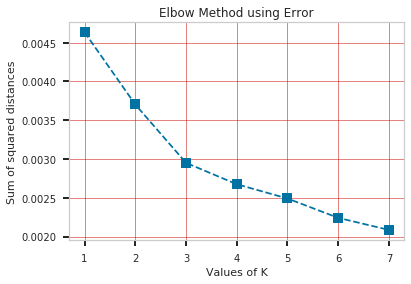

<Figure size 1080x864 with 0 Axes>

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
# Removing the neighborhood column
austin_res_clustering = austin_res.drop('Neighborhood', 1)
# Sum_of_squared_distances is a list of errors for each k value
Sum_of_squared_distances = []
K = range(1,8) 
for k in K: 
    #Building and fitting the model 
    km = KMeans(n_clusters=k) 
    km = km.fit(austin_res_clustering)
    Sum_of_squared_distances.append(km.inertia_/100)
# Making a simple plot of the elbow method
fig, ax = plt.subplots()
plt.figure(figsize=(15,12))
ax.plot(K, Sum_of_squared_distances,'bs--',markersize=10)
ax.set(xlabel='Values of K', ylabel='Sum of squared distances',
      title='Elbow Method using Error')
ax.tick_params(direction='out',length=6,width=2,grid_color='r',grid_alpha=0.5)
ax.grid(True)
#fig.savefig("test.png")
plt.show()

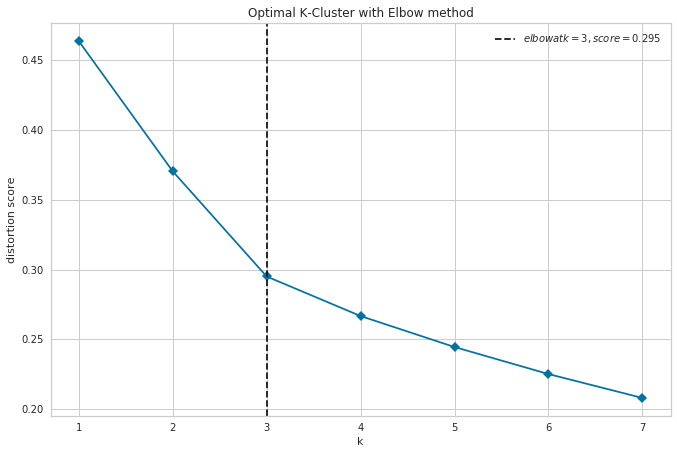

In [31]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
titleKElbow = "Optimal K-Cluster with Elbow method"
visualizer = KElbowVisualizer(model, k=(1,8),timings=False,title=titleKElbow,size=(800,520))
visualizer.fit(austin_res_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [32]:
# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_res_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 0, 1, 0, 2], dtype=int32)

### DataFrame that includes Neighborhood, Latitude, Longitude, Cluster labels as well as the top 10 restaurants for each neighborhood

In [33]:
# Let's add clustering labels to the restaurant dataframe
neighborhoods_res_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# New Dataframe copied from austin neighborhood dataframe
restaurant_merged = df_austin.copy()
# Merge the new dataframe with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
restaurant_merged = restaurant_merged.join(neighborhoods_res_sorted.set_index('Neighborhood'), on='Neighborhood')
# Let's drop the Centroid column
restaurant_merged.drop(["Centroid"],axis=1,inplace=True)
# Display the sorted dataframe
print("Shape of the final popular restaurant dataframe:",restaurant_merged.shape)
restaurant_merged.head() 

Shape of the final popular restaurant dataframe: (65, 14)


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allandale,30.340301,-97.745169,0,Food Truck,Mexican Restaurant,Thai Restaurant,New American Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant
1,Barton Hills,30.252021,-97.788367,0,Food Truck,Ethiopian Restaurant,Israeli Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
2,Bouldin Creek,30.251705,-97.755626,1,Food Truck,New American Restaurant,Italian Restaurant,Thai Restaurant,Mexican Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant
3,Brentwood,30.330625,-97.732451,1,Mexican Restaurant,American Restaurant,Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Falafel Restaurant,Korean Restaurant,Mediterranean Restaurant,Japanese Restaurant,Food Truck
4,Central East Austin,30.269742,-97.724153,0,Food Truck,Mexican Restaurant,Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Indian Restaurant


## Let's visualize the restaurant clusters in Austin Neighborhood

In [34]:
# Import Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
restaurant_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.flag(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, point, cluster in zip(restaurant_merged['Latitude'], restaurant_merged['Longitude'], restaurant_merged['Neighborhood'], restaurant_merged['Cluster Labels']):
    label = folium.Popup(str(point) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1).add_to(restaurant_clusters)
# Save map
restaurant_clusters.save("figs/Austin_Restaurants_Clustered_Map.html")
# Display map   
HTML(restaurant_clusters._repr_html_())

# Examine the Restautant Clusters

### Let's examine Cluster # 1

In [35]:
restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 0, restaurant_merged.columns[[0] + list(range(4, restaurant_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allandale,Food Truck,Mexican Restaurant,Thai Restaurant,New American Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant
1,Barton Hills,Food Truck,Ethiopian Restaurant,Israeli Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
4,Central East Austin,Food Truck,Mexican Restaurant,Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Chinese Restaurant,Indian Restaurant
11,East Cesar Chavez,Food Truck,Mexican Restaurant,Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Korean Restaurant,Mediterranean Restaurant
12,East Congress,Food Truck,Restaurant,Asian Restaurant,Mexican Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant
13,East Oak Hill,Food Truck,Restaurant,Italian Restaurant,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant
14,Franklin Park,Food Truck,Mexican Restaurant,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
28,MLK-183,Food Truck,American Restaurant,Ethiopian Restaurant,Israeli Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant
29,Montopolis,Food Truck,American Restaurant,Latin American Restaurant,Mexican Restaurant,Fast Food Restaurant,Falafel Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant
31,North Burnet,Food Truck,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Asian Restaurant,Mediterranean Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant


### Let's examine Cluster # 2

In [36]:
restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 1, restaurant_merged.columns[[0] + list(range(4, restaurant_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bouldin Creek,Food Truck,New American Restaurant,Italian Restaurant,Thai Restaurant,Mexican Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant
3,Brentwood,Mexican Restaurant,American Restaurant,Thai Restaurant,Vietnamese Restaurant,Asian Restaurant,Falafel Restaurant,Korean Restaurant,Mediterranean Restaurant,Japanese Restaurant,Food Truck
5,Chestnut,American Restaurant,Mexican Restaurant,Food Truck,Southern / Soul Food Restaurant,Italian Restaurant,Mediterranean Restaurant,Peruvian Restaurant,Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant
7,Crestview,Mexican Restaurant,Japanese Restaurant,Food Truck,Korean Restaurant,Asian Restaurant,Thai Restaurant,Ethiopian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant
8,Dawson,Mexican Restaurant,Food Truck,Hawaiian Restaurant,Cuban Restaurant,African Restaurant,Argentinian Restaurant,Fast Food Restaurant,Indian Restaurant,Indian Chinese Restaurant,American Restaurant
9,Heritage Hills,Chinese Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Israeli Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant
10,Downtown,Food Truck,Italian Restaurant,Sushi Restaurant,New American Restaurant,Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cajun / Creole Restaurant,Middle Eastern Restaurant
15,Galindo,Mexican Restaurant,Food Truck,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
16,Highland,Korean Restaurant,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Peruvian Restaurant,American Restaurant,Caribbean Restaurant,Indian Restaurant,Middle Eastern Restaurant,Japanese Restaurant
17,Garrison Park,Mexican Restaurant,Food Truck,Chinese Restaurant,Fast Food Restaurant,Seafood Restaurant,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant


### Let's examine Cluster # 3

In [37]:
restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 2, restaurant_merged.columns[[0] + list(range(4, restaurant_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Coronado Hills,Mexican Restaurant,Fast Food Restaurant,Asian Restaurant,South American Restaurant,Comfort Food Restaurant,Vietnamese Restaurant,Falafel Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant
24,Johnston Terrace,Mexican Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
30,North Austin Civic Association,Mexican Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
37,Parker Lane,Vietnamese Restaurant,Mexican Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant
38,South Manchaca,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant
46,West Congress,Mexican Restaurant,Food Truck,Ethiopian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant
51,Sweetbriar,Mexican Restaurant,Fast Food Restaurant,Food Truck,Sushi Restaurant,Chinese Restaurant,Indian Restaurant,Tex-Mex Restaurant,Asian Restaurant,American Restaurant,Indian Chinese Restaurant
